# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [35]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [36]:
# loading the data:
customers = pd.read_csv('../Wholesale customers data.csv')

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [37]:
# Your code here:

# check the null values, the column names and the type of the variables
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


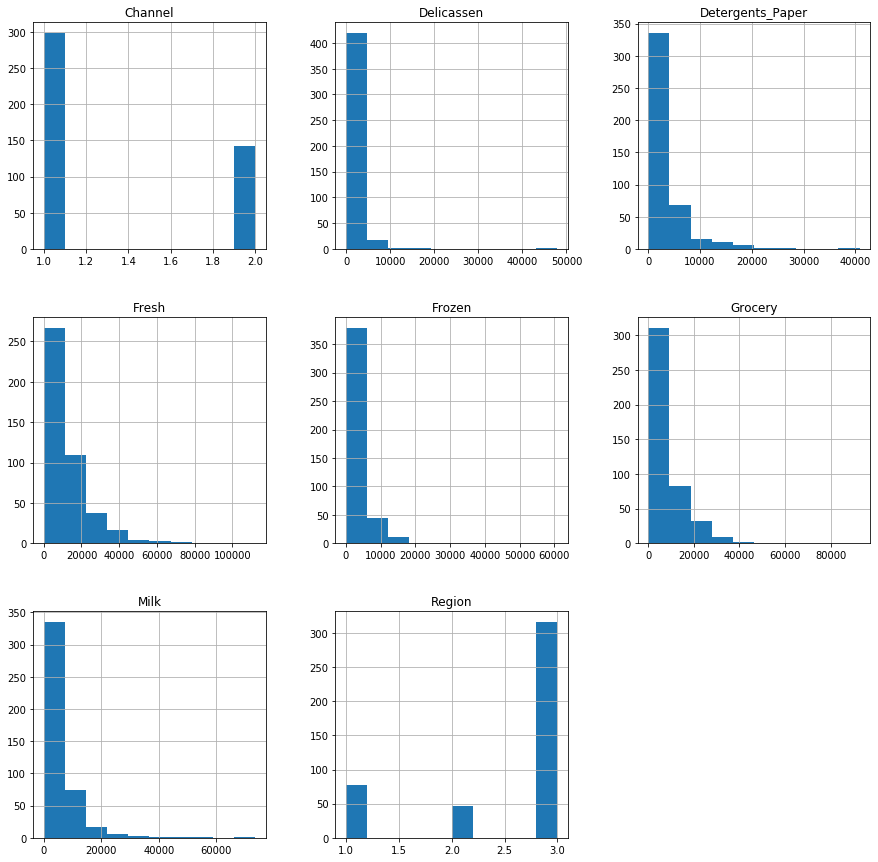

In [38]:
# plot the histograms of the features
customers.hist(figsize = (15,15))
plt.show()

In [39]:
# overview of stat data
customers.describe()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [40]:
# check the ratio max/mean to verify the amplitude of the outliers
col_to_treat = ['Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen']

for i in col_to_treat:
    print('the ratio max/mean is: ',customers[i].max()/customers[i].mean())
    
# I will remove all outliers that lead to a max/mean ratio above 9. I will perform this operation only once because I don't want to eliminate too much information from the dataset which is already not that big (442 rows)

the ratio max/mean is:  9.345684794562862
the ratio max/mean is:  12.680232610571775
the ratio max/mean is:  11.668565542071285
the ratio max/mean is:  19.814567380608885
the ratio max/mean is:  14.168695680979795
the ratio max/mean is:  31.440703606714727


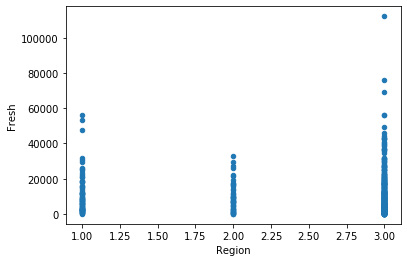

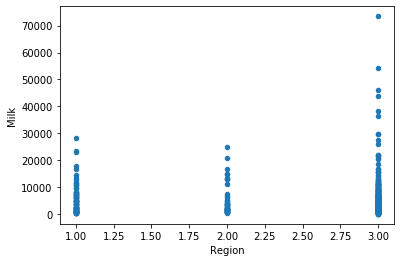

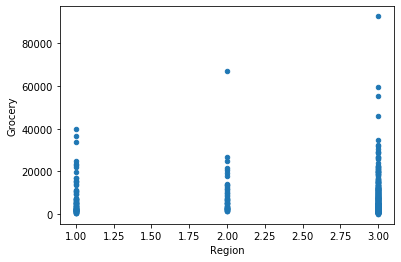

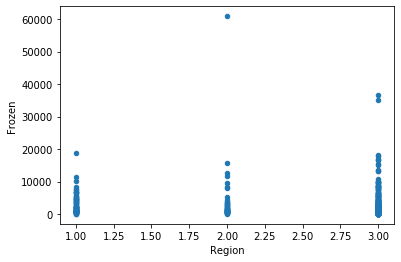

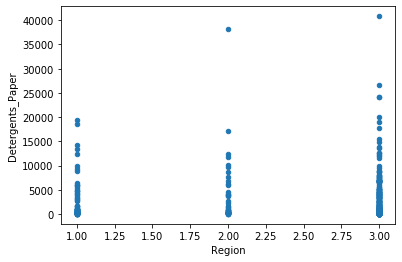

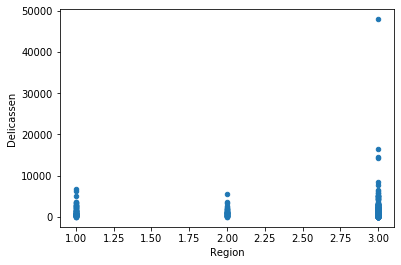

In [41]:

customers.plot.scatter(x='Region',y='Fresh')
customers.plot.scatter(x='Region',y='Milk')
customers.plot.scatter(x='Region',y='Grocery')
customers.plot.scatter(x='Region',y='Frozen')
customers.plot.scatter(x='Region',y='Detergents_Paper')
customers.plot.scatter(x='Region',y='Delicassen')


plt.show()

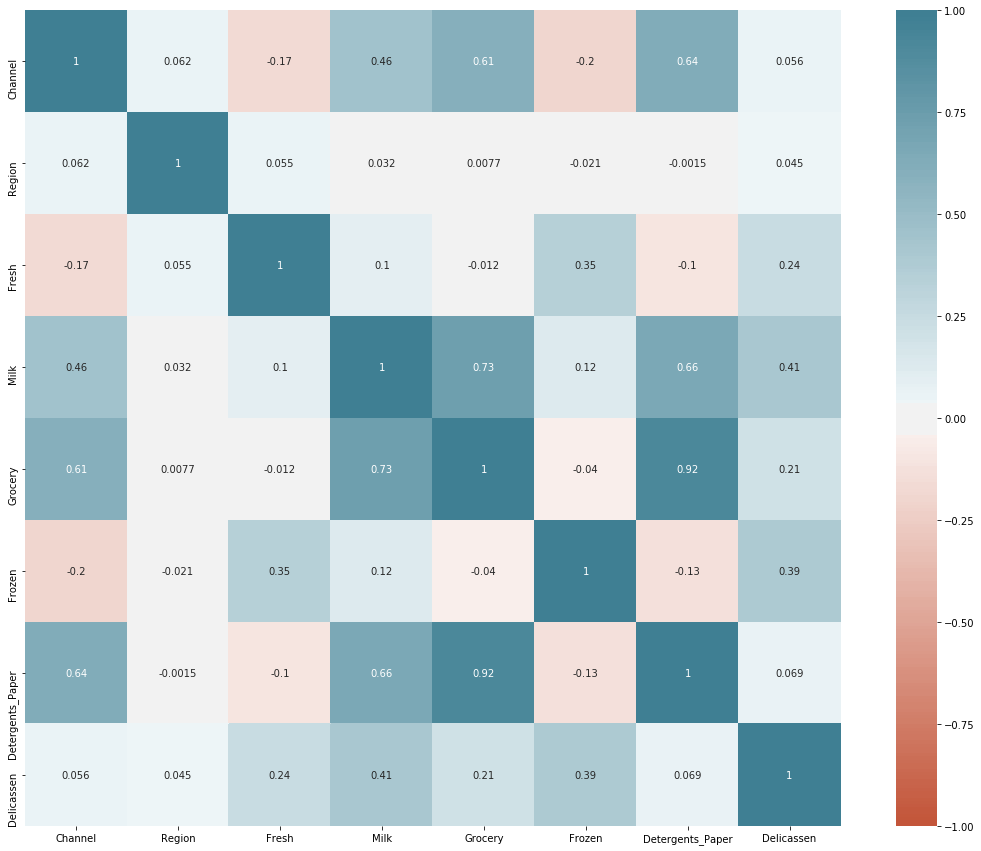

In [42]:
# Collinearity check
customers_corr = customers.corr()

import seaborn as sns
#define the size of the plot
plt.subplots(figsize=(20,15))
# define the heat map - CHANGE THE df
ax = sns.heatmap(
    customers_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True)

In [43]:
customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [44]:
# Your observations here

# no null data
# There are 3 regions considered and 2 different sales channels in the DataFrame. The sale of 6 products is considered
# the distribution of Delicassen, Detergen_papers, Fresh, Frozen, Grocery and Milk are skewed to the left
# Grocery and Detergents_Paper have a high correlation of 0.92 but considering that there are not too many features I will keep all the features
# there are important outliers in all products. We will therefore take out the max out of each product category

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [45]:
# Your code here
col_to_treat = ['Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen']

for i in col_to_treat:
    row_to_drop = customers[customers[i]==max(customers[i])]
    customers.drop(row_to_drop.index,axis=0,inplace = True)



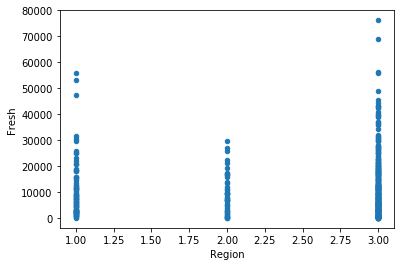

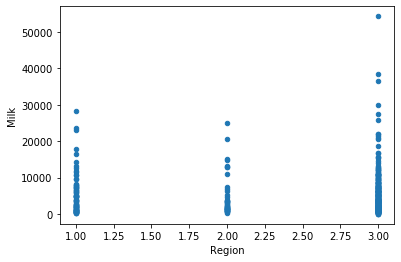

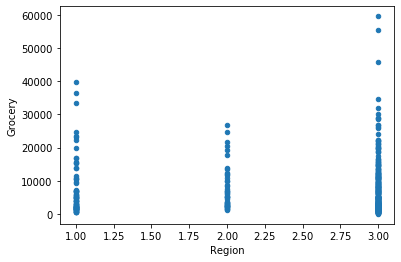

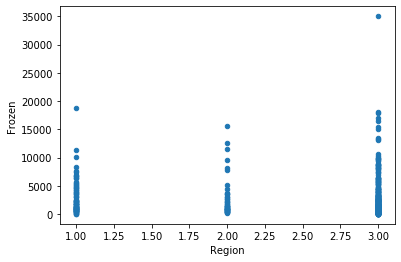

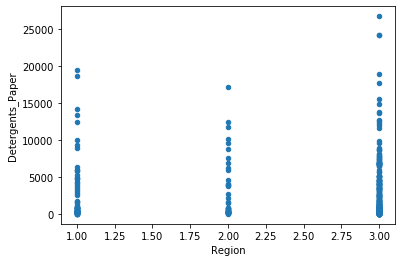

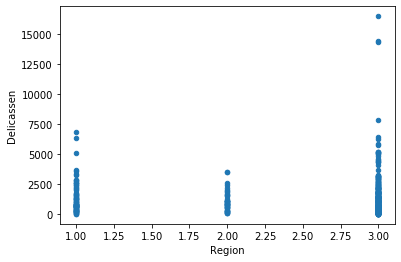

In [46]:
# verification that values were correctly dropped by plotting the scatters and comparing with the previous scatter plots
customers.plot.scatter(x='Region',y='Fresh')
customers.plot.scatter(x='Region',y='Milk')
customers.plot.scatter(x='Region',y='Grocery')
customers.plot.scatter(x='Region',y='Frozen')
customers.plot.scatter(x='Region',y='Detergents_Paper')
customers.plot.scatter(x='Region',y='Delicassen')


plt.show()

In [47]:
for i in col_to_treat:
    print('the ratio max/mean is: ',customers[i].max()/customers[i].mean())

the ratio max/mean is:  6.550803643535125
the ratio max/mean is:  10.08358422675084
the ratio max/mean is:  7.947801547799827
the ratio max/mean is:  12.299192622705322
the ratio max/mean is:  9.969239478010563
the ratio max/mean is:  11.876832417159259


In [ ]:
# Your comment here
# the main outliers have been removed, the ratio max/mean are 12 or less which are considered acceptable in view of the scatter plots

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [52]:
# Your import here:

from sklearn.preprocessing import StandardScaler

# Your code here:

# defining standardization object
scaler = StandardScaler()

# fitting standardization object
scaler.fit(customers[col_to_treat])

# transforming
customers_scale = scaler.transform(customers[col_to_treat])

customers_scale

array([[ 8.84881194e-02,  7.15895447e-01,  7.76326199e-03,
        -7.28955560e-01, -1.08249767e-03, -3.12148860e-02],
       [-3.93086301e-01,  7.41683970e-01,  2.57766819e-01,
        -3.00296140e-01,  1.53356519e-01,  2.25799889e-01],
       [-4.53497633e-01,  5.73891110e-01,  2.30848551e-02,
        -1.22241871e-01,  2.08994485e-01,  3.78645207e+00],
       ...,
       [ 2.48269226e-01,  1.69251018e+00,  2.83316469e+00,
        -6.67204235e-01,  3.03455485e+00,  2.79197936e-01],
       [-1.15657559e-01, -5.69344279e-01, -6.56047876e-01,
        -5.00780261e-01, -6.26323494e-01,  4.30590201e-01],
       [-7.59501621e-01, -6.16734877e-01, -6.21418584e-01,
        -7.70215414e-01, -5.49228734e-01, -7.85829043e-01]])

# Challenge 4 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [66]:
# Your code here:

from sklearn.cluster import KMeans

#initialize your clustering
kmeans = KMeans(n_clusters= 4, random_state=0)

# fitting  - creating the clusters based on the data of the features
kmeans.fit(customers_scale)

# return the centers of each centroid
kmeans.cluster_centers_

# showing the cluster label of each datapoint inside the data-returns an array
customers['labels'] = kmeans.labels_

customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels
0,2,3,12669,9656,7561,214,2674,1338,3
1,2,3,7057,9810,9568,1762,3293,1776,3
2,2,3,6353,8808,7684,2405,3516,7844,3
3,1,3,13265,1196,4221,6404,507,1788,0
4,2,3,22615,5410,7198,3915,1777,5185,2


Count the values in `labels`.

In [67]:
# Your code here:

customers['labels'].value_counts()


0    246
3    109
2     61
1     18
Name: labels, dtype: int64

# Challenge 5 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [68]:
# Your code here
from sklearn.cluster import DBSCAN

#initialize your clustering
dbscan = DBSCAN(eps=0.5)

# fitting  - creating the clusters based on the data of the features
dbscan.fit(customers_scale)

# showing the cluster label of each datapoint inside the data-returns an array
customers['labels_DBSCAN'] = dbscan.labels_

customers.head()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels,labels_DBSCAN
0,2,3,12669,9656,7561,214,2674,1338,3,-1
1,2,3,7057,9810,9568,1762,3293,1776,3,1
2,2,3,6353,8808,7684,2405,3516,7844,3,-1
3,1,3,13265,1196,4221,6404,507,1788,0,-1
4,2,3,22615,5410,7198,3915,1777,5185,2,-1


Count the values in `labels_DBSCAN`.

In [69]:
# Your code here

customers['labels_DBSCAN'].value_counts()




-1    245
 0    168
 1     11
 3      6
 2      4
Name: labels_DBSCAN, dtype: int64

In [ ]:
# noisy points are given the value -1 so we have 245 noisy points in this case

# Challenge 6 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

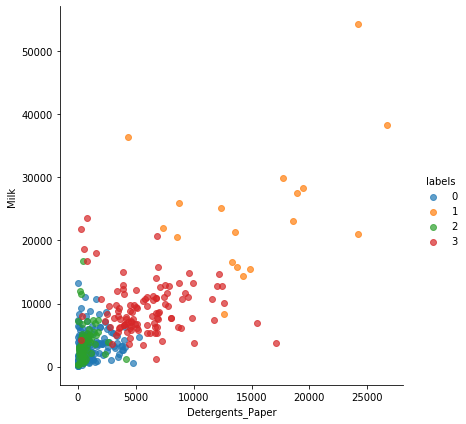

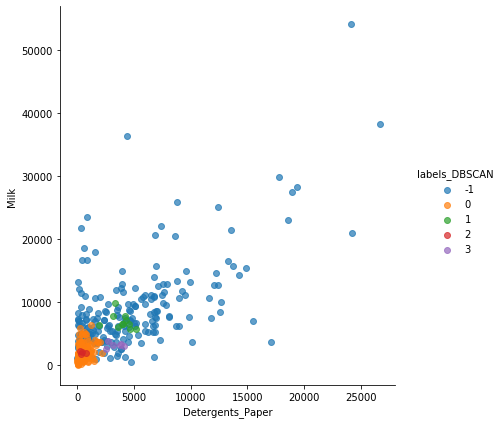

In [155]:
k = sns.FacetGrid(data = customers, hue="labels",margin_titles=True,size=6)
k.map(plt.scatter, "Detergents_Paper", "Milk", alpha=.7)
k.add_legend()

d = sns.FacetGrid(data = customers, hue="labels_DBSCAN",margin_titles=True,size=6)
d.map(plt.scatter, "Detergents_Paper", "Milk", alpha=.7)
d.add_legend()

plt.show()

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

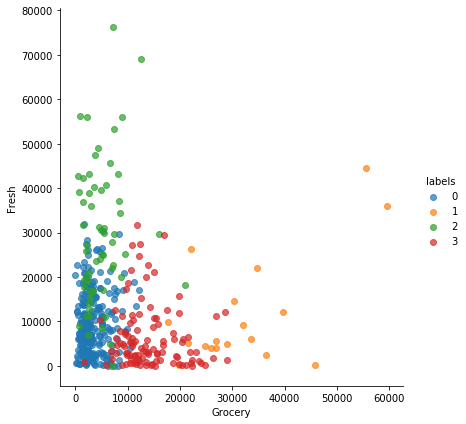

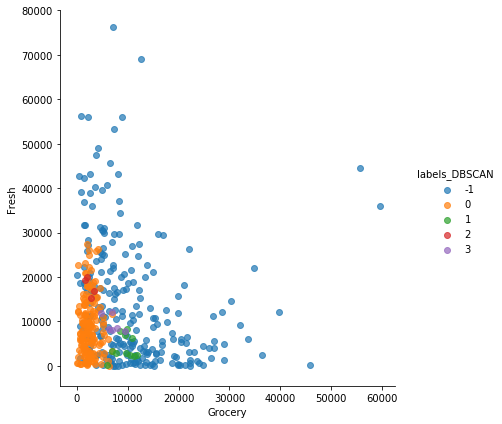

In [156]:
# Your code here:

k = sns.FacetGrid(data = customers, hue="labels",margin_titles=True,size=6)
k.map(plt.scatter, "Grocery", "Fresh", alpha=.7)
k.add_legend()

d = sns.FacetGrid(data = customers, hue="labels_DBSCAN",margin_titles=True,size=6)
d.map(plt.scatter, "Grocery", "Fresh", alpha=.7)
d.add_legend()

plt.show()

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

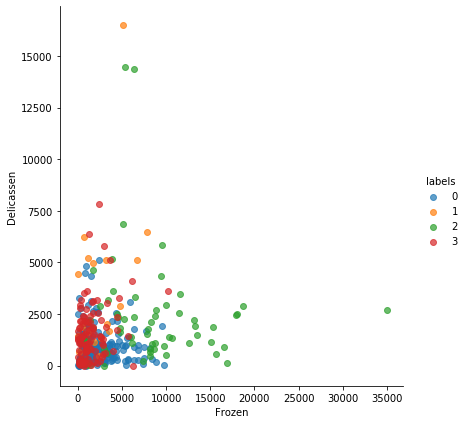

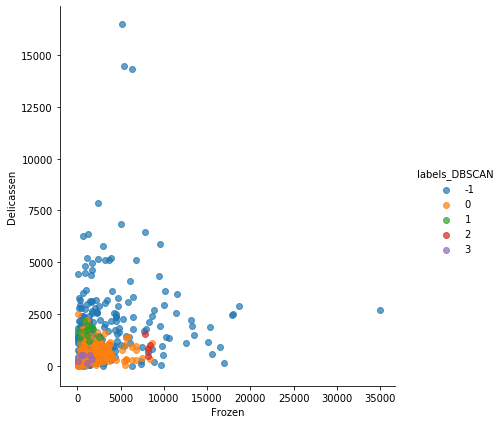

In [157]:
# Your code here:

k = sns.FacetGrid(data = customers, hue="labels",margin_titles=True,size=6)
k.map(plt.scatter, "Frozen", "Delicassen", alpha=.7)
k.add_legend()

d = sns.FacetGrid(data = customers, hue="labels_DBSCAN",margin_titles=True,size=6)
d.map(plt.scatter, "Frozen", "Delicassen", alpha=.7)
d.add_legend()

plt.show()

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [165]:
# Your code here:


customers.groupby(by="labels").mean()



,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels_DBSCAN
labels,,,,,,,,,
0,1.093496,2.508130,9516.955285,2652.369919,3400.296748,2095.886179,814.971545,902.597561,-0.215447
1,2.000000,2.500000,11764.000000,24683.444444,32342.500000,2589.166667,15195.111111,3845.333333,-1.000000
2,1.098361,2.639344,29406.262295,3929.163934,4898.163934,8390.885246,727.393443,2355.721311,-0.786885
3,1.844037,2.568807,6459.669725,9163.825688,14100.917431,1480.009174,5908.559633,1548.853211,-0.816514


In [164]:
customers.groupby(by="labels_DBSCAN").mean()



,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels
labels_DBSCAN,,,,,,,,,
-1,1.497959,2.575510,13868.493878,7832.318367,10983.767347,3426.228571,4179.187755,1893.648980,1.742857
0,1.023810,2.482143,8803.339286,1864.000000,2433.190476,2052.369048,441.208333,686.910714,0.011905
1,1.727273,2.454545,4158.727273,6915.272727,9301.181818,1185.090909,3880.181818,1666.727273,2.727273
2,1.000000,2.750000,17902.750000,2009.500000,2453.500000,8143.500000,415.250000,958.500000,2.000000
3,1.833333,2.833333,9451.666667,3190.833333,7083.333333,920.666667,3338.666667,377.666667,0.000000


Which algorithm appears to perform better?

In [167]:
# Your observations here
# the computed means give an idea of the centroids of the clusters, however it is difficult to read
# the best way to assess which algorithm performs better, I compute the silhouette of the models

from sklearn import metrics

#for X in col_to_treat:
    
print("Silhouette Coefficient with KMean: %0.3f"
          % metrics.silhouette_score(customers_scale, customers['labels']))
print("Silhouette Coefficient with DBScan for variable : %0.3f"
          % metrics.silhouette_score(customers_scale, customers['labels_DBSCAN']))

# computing these metrics we notice that KMean gives a better result in clustering the data

Silhouette Coefficient with KMean: 0.326
Silhouette Coefficient with DBScan for variable : -0.176


# Bonus Challenge 1 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [ ]:
# Your code here

In [ ]:
# Your comment here

# Bonus Challenge 2 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [ ]:
# Your code here

In [ ]:
# Your comment here